In [1]:
from fit.datamodules.tomo_rec import Kanji_TRecFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D, get_polar_rfft_coords_sinogram
from fit.utils import denormalize, convert2DFT
from fit.modules import TRecTransformerModule

from matplotlib import pyplot as plt

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint

import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from os.path import exists

In [2]:
seed_everything(22122020)

Global seed set to 22122020


22122020

In [3]:
dm = Kanji_TRecFITDM(root_dir='./datamodules/data/Kanji', batch_size=8, num_angles=33)

dm.prepare_data()
dm.setup()

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
angles = dm.gt_ds.get_ray_trafo().geometry.angles
det_len = dm.gt_ds.get_ray_trafo().geometry.detector.shape[0]

In [5]:
img_shape = dm.gt_shape

In [6]:
proj_r, proj_phi, src_flatten = get_polar_rfft_coords_sinogram(angles=angles, 
                                                               det_len=det_len)
target_r, target_phi, dst_flatten, order = get_polar_rfft_coords_2D(img_shape=img_shape)

In [7]:
n_heads = 8
d_query = 32
model = TRecTransformerModule(d_model=n_heads * d_query, 
                              sinogram_coords=(proj_r, proj_phi),
                              target_coords=(target_r, target_phi),
                              src_flatten_coords=src_flatten, 
                              dst_flatten_coords=dst_flatten, 
                              dst_order=order,
                              angles=angles, 
                              img_shape=img_shape,
                              detector_len=det_len,
                              lr=0.0005, 
                              weight_decay=0.01, 
                              attention_type='linear', 
                              n_layers=4,
                              n_heads=n_heads, 
                              d_query=d_query, 
                              dropout=0.1, 
                              attention_dropout=0.1)

In [12]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor

In [13]:
wandb_logger = WandbLogger(project="fit", id='test_v0.2.4', resume='allow')

In [14]:
trainer = Trainer(logger=wandb_logger, max_epochs=120, 
                  gpus=1,
                  callbacks=[ModelCheckpoint(
                                            dirpath='./trec_kanji_prod_v0.2.4/',
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_mse',
                                            mode='min'
                                        ),
                            LearningRateMonitor()], 
                  deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
# Uncomment the next line if you want to train your own model. 
trainer.fit(model, datamodule=dm);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
wandb: Currently logged in as: tibuch (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name | Type            | Params
-----------------------------------------
0 | trec | TRecTransformer | 7.4 M 
-----------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.497    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 22122020
/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/fit/utils/RAdam.py:119: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [10]:
if not exists('./models/trec_kanji/kanji_trec.ckpt'):
    wget.download('https://download.fht.org/jug/fit/trec_model_kanji.ckpt',
                  out='./models/trec_kanji/kanji_trec.ckpt')
    
if not exists('./models/trec_kanji/kanji_trec_fbp.ckpt'):
    wget.download('https://download.fht.org/jug/fit/trec_fbp_model_kanji.ckpt',
                  out='./models/trec_kanji/kanji_trec_fbp.ckpt')

In [11]:
if with_fbp:
    path = './models/trec_kanji/kanji_trec_fbp.ckpt'
else:
    path = './models/trec_kanji/kanji_trec.ckpt'

In [10]:
trainer = Trainer(max_epochs=120, 
                  gpus=1,
                  deterministic=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [11]:
model = TRecTransformerModule.load_from_checkpoint('models/trec_kanji/sum_v0.2.2/epoch=48-step=20432.ckpt', 
                                               sinogram_coords=(proj_r, proj_phi),
                              target_coords=(target_r, target_phi),
                              src_flatten_coords=src_flatten, 
                              dst_flatten_coords=dst_flatten, 
                              dst_order=order, angles=angles, strict=False)

In [12]:
test_res = trainer.test(model, datamodule=dm)

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

29.844524383544922
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Mean PSNR': 29.844524383544922, 'SEM PSNR': 0.029386263340711594}
--------------------------------------------------------------------------------


In [13]:
i = 0
for x_fc, fbp_fc, y_fc, y_real, (amp_min, amp_max) in dm.test_dataloader():
    if i >= 0:
        break
    i+=1

In [14]:
model.cpu();

In [15]:
pred_img, pred_img_before_conv = model.get_imgs(x_fc, fbp_fc, y_fc, amp_min, amp_max)

/tungstenfs/scratch/gmicro_share/_software/CondaEnvs/Linux/FDE_so/lib/python3.8/site-packages/fit/modules/TRecTransformerModule.py:350: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/Copy.cpp:244.)
  pred_fc_[:, :tmp.shape[1]] = tmp


In [16]:
def norm255(img):
    return (img - img.min()) * 255 / (img.max() - img.min())

In [17]:
# Before the projection we normalized the image, now we undo this for the visualization.
# After denormalization we set all pixels outside of the projection-area to zero
pred_img_before_conv = denormalize(pred_img_before_conv, dm.mean, dm.std) * dm.__get_circle__()
pred_img = denormalize(pred_img, dm.mean, dm.std) * dm.__get_circle__()
y_real = denormalize(y_real, dm.mean, dm.std) * dm.__get_circle__()

In [18]:
dft_fbp = convert2DFT(x=fbp_fc[:,model.dst_flatten_order], amp_min=amp_min, amp_max=amp_max,
                              dst_flatten_order=model.dst_flatten_order, img_shape=model.hparams.img_shape)
fbp_img = torch.roll(torch.fft.irfftn(model.mask * dft_fbp[0], s=2 * (model.hparams.img_shape,)),
                     2 * (model.hparams.img_shape // 2,), (0, 1))

fbp_img = (fbp_img - fbp_img.min())*255/(fbp_img.max() - fbp_img.min())
fbp_img = fbp_img * dm.__get_circle__()

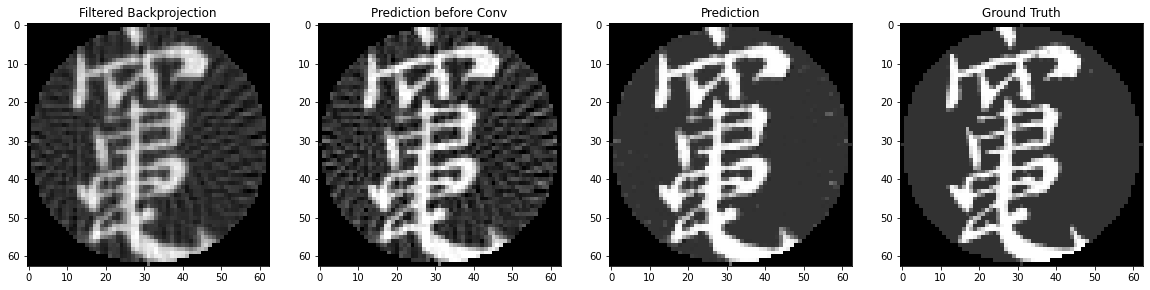

In [19]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(fbp_img, cmap='gray', vmin=y_real[0].min(), vmax=y_real[0].max())
plt.title('Filtered Backprojection');
plt.subplot(1,4,2)
plt.imshow(pred_img_before_conv[0].detach(), cmap='gray', vmin=y_real[0].min(), vmax=y_real[0].max())
plt.title('Prediction before Conv');
plt.subplot(1,4,3)
plt.imshow(pred_img[0].detach(), cmap='gray', vmin=y_real[0].min(), vmax=y_real[0].max())
plt.title('Prediction');
plt.subplot(1,4,4)
plt.imshow(y_real[0], cmap='gray')
plt.title('Ground Truth');

In [20]:
from fit.utils import PSNR

In [21]:
PSNR(y_real[0], fbp_img, y_real[0].max() - y_real[0].min())

tensor(21.9413)

In [22]:
PSNR(y_real[0], pred_img[0].detach(), y_real[0].max() - y_real[0].min())

tensor(26.4025)

In [23]:
PSNR(y_real[0], pred_img_before_conv[0].detach(), y_real[0].max() - y_real[0].min())

tensor(21.9316)

In [203]:
fbp_psnrs = []
i = 0
for x_fc, fbp_fc, y_fc, y_real, (amp_min, amp_max) in dm.test_dataloader():
    dft_fbp = convert2DFT(x=fbp_fc[:,model.dst_flatten_order], amp_min=amp_min, amp_max=amp_max,
                              dst_flatten_order=model.dst_flatten_order, img_shape=model.hparams.img_shape)
    fbp_img = torch.roll(torch.fft.irfftn(model.mask * dft_fbp[0], s=2 * (model.hparams.img_shape,)),
                         2 * (model.hparams.img_shape // 2,), (0, 1))

    fbp_img = (fbp_img - fbp_img.min())*255/(fbp_img.max() - fbp_img.min())
    fbp_img = fbp_img * dm.__get_circle__()
    
    y_real = denormalize(y_real, dm.mean, dm.std) * dm.__get_circle__()
    fbp_psnrs.append(PSNR(y_real[0], fbp_img, y_real[0].max() - y_real[0].min()))

    i+=1
    if i >= 5000:
        break

In [205]:
np.mean(fbp_psnrs)

24.692612

In [209]:
np.std(fbp_psnrs/np.sqrt(len(fbp_psnrs)))

0.015398125

In [273]:
fbp_psnrs = []
i = 0
for x_fc, fbp_fc, y_fc, y_real, (amp_min, amp_max) in dm.test_dataloader():
    pred_img, pred_img_before_conv = model.get_imgs(x_fc, fbp_fc, y_fc, amp_min, amp_max)
    pred_img_before_conv = denormalize(pred_img_before_conv, dm.mean, dm.std) * dm.__get_circle__()

    y_real = denormalize(y_real, dm.mean, dm.std) * dm.__get_circle__()
    fbp_psnrs.append(PSNR(y_real[0], pred_img_before_conv[0].detach(), y_real[0].max() - y_real[0].min()))
    
    i+=1
    if i >= 5000:
        break

In [274]:
np.mean(fbp_psnrs)

25.497286

In [275]:
np.std(fbp_psnrs/np.sqrt(len(fbp_psnrs)))

0.022698313

In [ ]:
model.